## <center style="color:blue;">**SparkAttriNet**</center>

Dans le secteur bancaire, anticiper la perte de clients est essentiel pour réduire le taux d’attrition et renforcer la fidélisation. 

Ce projet exploite la puissance de PySpark pour analyser de grands volumes de données, MLlib pour entraîner un modèle prédictif, MongoDB pour stocker les données transformées, et Streamlit pour visualiser les résultats et faciliter la prise de décision.

<br>

### <span style="color:green;">**Imputation des Valeurs Manquantes :**</span>

#### <span style="color:orange;">**1. Créer une session Spark :**</span>

In [88]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkAttriNet - Prédiction de l'Attrition Client Bancaire") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print("Session Créée avec Succès !")

Session Créée avec Succès !


#### <span style="color:orange;">**2. Charger les données :**</span>

In [89]:
df = spark.read.csv(
    "../data/raw/data.csv",
    header=True,
    inferSchema=True
)

print("Données Chargées avec Succès !")

Données Chargées avec Succès !


#### <span style="color:orange;">**3. Identifier les Valeurs Manquantes :**</span>

##### **3.1. Séparer les Colonnes en fonction du Type des Données :**

In [90]:
numeric_cols = []
string_cols = []

for col, type in df.dtypes :
    if type in ["int", "double"] :
        numeric_cols.append(col)
    else :
        string_cols.append(col)

print(numeric_cols)
print(string_cols)

['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
['Surname', 'Geography', 'Gender']


##### **3.2. Identifier le Nombre des Valeurs Manquantes pour Chaque Colonne Numérique :**

In [91]:
from pyspark.sql import functions as F

missing_numeric = df.select([
    F.sum(
        (F.col(c).isNull() | F.isnan(F.col(c))).cast("int")
    ).alias(c)
    for c in numeric_cols
])

missing_numeric.show()


+---------+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|CreditScore|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|          0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+------+



##### **3.3. Identifier le Nombre des Valeurs Manquantes pour Chaque Colonne String :**

In [92]:
from pyspark.sql import functions as F

missing_string = df.select([
    F.sum(
        (F.col(c).isNull() | (F.col(c) == "")).cast("int")
    ).alias(c)
    for c in string_cols
])

missing_string.show()


+-------+---------+------+
|Surname|Geography|Gender|
+-------+---------+------+
|      0|        0|     0|
+-------+---------+------+



##### **3.4. Conclusion :**

- Aucune donnée manquante dans l’ensemble du DataFrame, ni dans les colonnes ``numériques`` ni dans les colonnes ``texte``.

- Les données sont donc prêtes pour l’analyse exploratoire ou la modélisation, sans avoir besoin d’imputation ou de nettoyage pour les valeurs manquantes.

<br>

### <span style="color:green;">**Suppression des Colonnes Non Pertinentes :**</span>

Dans notre cas de prédiction d’attrition client bancaire, l'objectif est de **Prédire ``Exited``** (la variable cible).

On cherche donc à identifier les variables explicatives réellement utiles au modèle.

Les Données disponibles sont :

In [93]:
cols = numeric_cols + string_cols

cols

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'Surname',
 'Geography',
 'Gender']

Donc les **colonnes non pertinentes** (à supprimer avant l’entraînement), sont :

<br>

| Colonne        | Raison                                                                                |
| -------------- | ------------------------------------------------------------------------------------- |
| RowNumber  | Juste un index du dataset qui n'a aucune valeur informative.                          |
| CustomerId | Identifiant unique client qui n'a pas de corrélation au comportement et qui peut affecter un risque de surapprentissage. |
| Surname    | Nom du client est aussi non pertinent.           |


In [94]:
colonnes_a_supprimer = ["RowNumber", "CustomerId", "Surname"]

df = df.drop(*colonnes_a_supprimer)


df.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [95]:
numeric_cols = []
string_cols = []

for col, type in df.dtypes :
    if type in ["int", "double"] :
        numeric_cols.append(col)
    else :
        string_cols.append(col)

print(numeric_cols)
print(string_cols)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
['Geography', 'Gender']


<br>

### <span style="color:green;">**Gestion des Valeurs Abberantes :**</span>

#### <span style="color:orange;">**1. Identifier les Colonnes avec des Outliers :**</span>

D'après l'Analyse Exploratoire des Données (EDA) précédente et en se basant sur les histogrammes et les boxplots, il existe 2 colonnes principales qui nécessitent une gestion des outliers :

- Le Colonne de l'**Age** ( > 78 ).

- Le Colonne de **CreditScore** ( < 400 ).

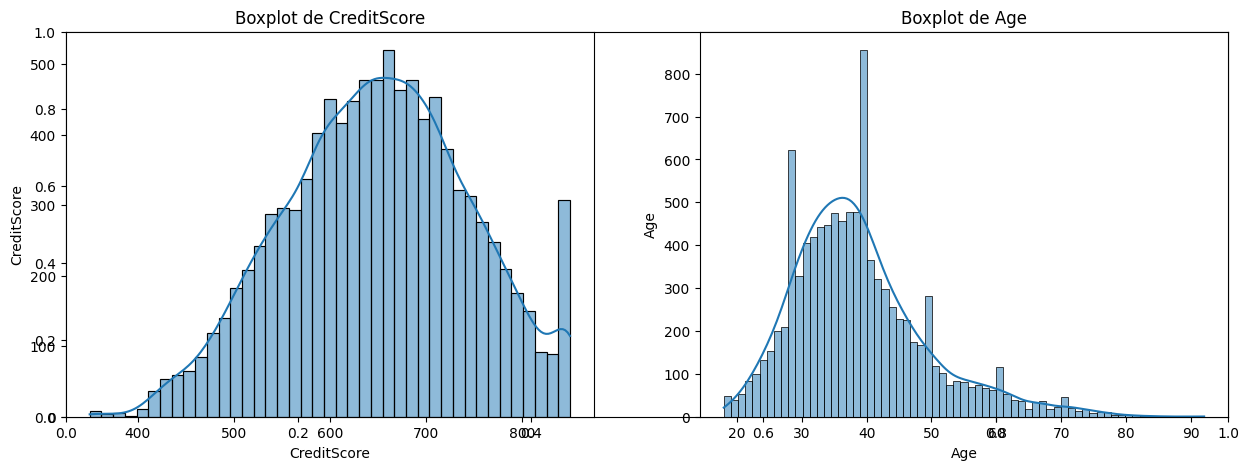

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.subplots(figsize=(15,5))

for i, col in enumerate(numeric_cols[:2]) :
    p_df = df.select(col).toPandas()
    
    plt.subplot(1, 2, i+1)
    sns.histplot(p_df[col], edgecolor="black", kde=True)
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)

plt.show()

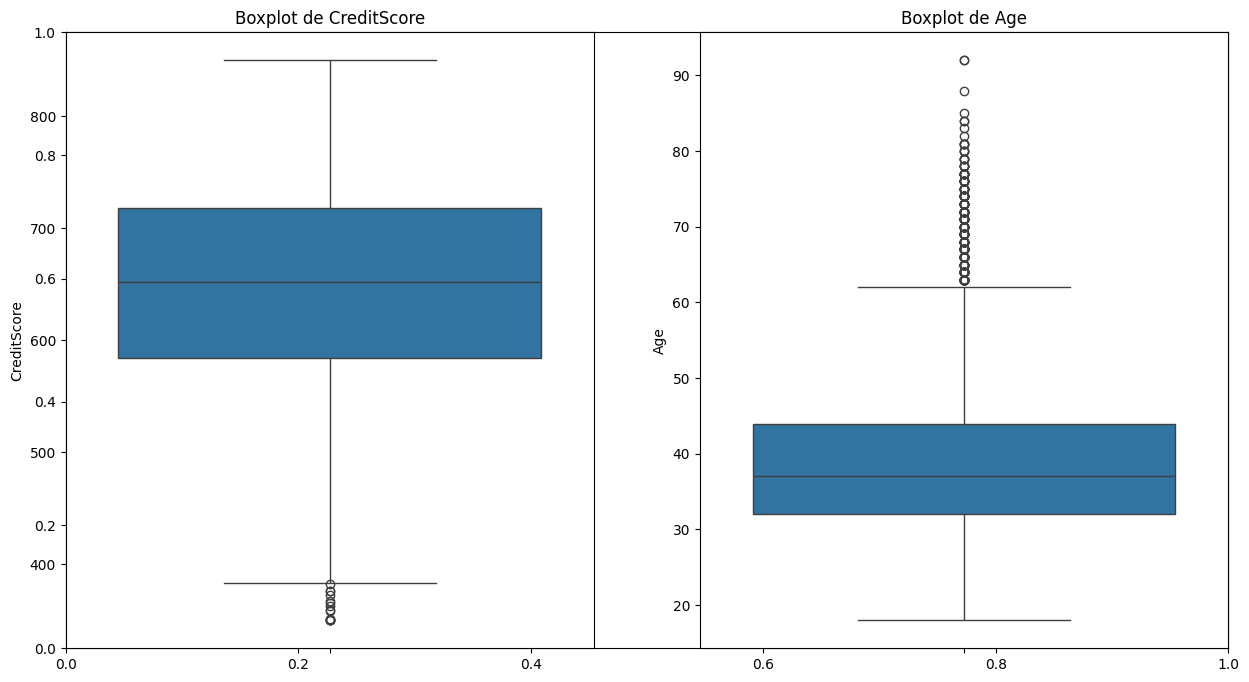

In [97]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(numeric_cols[:2]) :
    p_df = df.select(col).toPandas()

    plt.subplot(1, 2, i+1)
    sns.boxplot(p_df[col])
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)

plt.show()

##### **1.1. Gérer les Outliers de la Colonne ``Age`` :**

In [98]:
Q1, Q3 = df.approxQuantile("Age", [0.25, 0.75], 0.01)

IQR = Q3 - Q1

upper_bound = Q3 + 3.4 * IQR
lower_bound = Q1 - 3.4 * IQR

print(f"- lower_bound = {lower_bound:.2f}\n- upper_bound = {upper_bound:.2f}\n")

print("- Avant Suppression :", df.count())

df = df.filter((F.col("Age") >= lower_bound) & (F.col("Age") <= upper_bound))

print("- Après Suppression :", df.count())

- lower_bound = -8.80
- upper_bound = 84.80

- Avant Suppression : 10000
- Après Suppression : 9996


##### **1.2. Gérer les Outliers de la Colonne ``CreditScore`` :**

In [99]:
Q1, Q3 = df.approxQuantile("CreditScore", [0.25, 0.75], 0.01)

IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

print(f"- lower_bound = {lower_bound:.2f}\n- upper_bound = {upper_bound:.2f}\n")

df = df.withColumn(
    "CreditScore",
    F.when(F.col("CreditScore") < lower_bound, lower_bound)
     .otherwise(F.col("CreditScore"))
)

nb_outliers = df.filter(
    (F.col("CreditScore") < lower_bound) | (F.col("CreditScore") > upper_bound)
).count()

print(f"Nombre d'outliers : {nb_outliers}")


- lower_bound = 383.50
- upper_bound = 915.50

Nombre d'outliers : 0


<br>

### <span style="color:green;">**Encodage des Variables Catégorielles :**</span>

#### <span style="color:orange;">**1. Encoder la Colonne ``Gender`` :**</span>

In [100]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(
    inputCol="Gender",
    outputCol="Sex"
)

df = indexer.fit(df).transform(df)

df = df.drop(*["Gender"])

df.show()

+-----------+---------+---+------+---------+-------------+---------+--------------+---------------+------+---+
|CreditScore|Geography|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Sex|
+-----------+---------+---+------+---------+-------------+---------+--------------+---------------+------+---+
|      619.0|   France| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|1.0|
|      608.0|    Spain| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|1.0|
|      502.0|   France| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|1.0|
|      699.0|   France| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|1.0|
|      850.0|    Spain| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|1.0|
|      645.0|    Spain| 44|     8|113755.78|            2|        1|             0|      149756.71|     1|0.0|
|

#### <span style="color:orange;">**2. Encoder la Colonne ``Geography`` :**</span>

In [101]:
indexer = StringIndexer(inputCol="Geography", outputCol="Region")
df = indexer.fit(df).transform(df)
df = df.drop(*["Geography"])
df.show()

+-----------+---+------+---------+-------------+---------+--------------+---------------+------+---+------+
|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Sex|Region|
+-----------+---+------+---------+-------------+---------+--------------+---------------+------+---+------+
|      619.0| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|1.0|   0.0|
|      608.0| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|1.0|   2.0|
|      502.0| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|1.0|   0.0|
|      699.0| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|1.0|   0.0|
|      850.0| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|1.0|   2.0|
|      645.0| 44|     8|113755.78|            2|        1|             0|      149756.71|     1|0.0|   2.0|
|      822.0| 50|     7|    

#### <span style="color:orange;">**3. Réorganisation des Colonnes du DataFrame :**</span>

In [102]:
colonnes = ["Sex", "Region", "CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]

df = df.select(*colonnes)

df.show()

+---+------+-----------+---+------+---------+-------------+---------+--------------+---------------+------+
|Sex|Region|CreditScore|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---+------+-----------+---+------+---------+-------------+---------+--------------+---------------+------+
|1.0|   0.0|      619.0| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|1.0|   2.0|      608.0| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|1.0|   0.0|      502.0| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|1.0|   0.0|      699.0| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|1.0|   2.0|      850.0| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|
|0.0|   2.0|      645.0| 44|     8|113755.78|            2|        1|             0|      149756.71|     1|
|0.0|   0.0|      822.0| 50|

<br>

### <span style="color:green;">**Sauvegarde des Données Prétraitées :**</span>

In [106]:
clean_df = df.toPandas()

clean_df.to_csv("../data/processed/data.csv", index=False)

print("Données Sauvegardées avec Succès !")

clean_df.head()

Données Sauvegardées avec Succès !


,Sex,Region,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1.0,0.0,619.0,42,2,0.00,1,1,1,101348.88,1
1,1.0,2.0,608.0,41,1,83807.86,1,0,1,112542.58,0
2,1.0,0.0,502.0,42,8,159660.80,3,1,0,113931.57,1
3,1.0,0.0,699.0,39,1,0.00,2,0,0,93826.63,0
4,1.0,2.0,850.0,43,2,125510.82,1,1,1,79084.10,0
